# Notebook to compute deformation map of the wing disc pouch

In [1]:
from WDeversion_theory_methods import prop_comparison_methods as pcm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%load_ext
%autoreload 2

UsageError: Missing module name.


First we set some parameters for this notebook

In [2]:
#all of this can be put into a function 

#first we select the genotype 
genotype = 'ecadGFPnbG4'
#genotype = 'ecadGFPnbG4myoVI'

#some lists and dicts that we refer to later

#update names of devstages
devstage_map = {
                "96hAEL":"96hAEL",
                "120hAEL":"120hAEL",
                "upcrawling":"wL3",
                "whitePupa":"0hAPF",
                "2hAPF":"2hAPF",
                "4hAPF":"4hAPF",
                "6hAPF":"6hAPF",
               }

#declare colors for each devstage and crosssection and region
color_dict = {
              '96hAEL':'#f1ef81',
              '120hAEL':'#efa636',
              'wL3':'#414243',
              '0hAPF':'#7d99cd', 
              '2hAPF':'#64a9dd', 
              '4hAPF':'#78cfdb',
              '6hAPF':'#71c382',
              'DV' : 'purple',
              'outDV' : 'green',
             }

columns = ['devstage', 'discName', 'region', 'k_dist', #'roi',
           'area','neighbour_number','elongation_tensor_norm_max', 
           'Qrr_geom_inPlane', 'Qphiphi', 'Qnn', 'Qrphi', 'Qrn', 'Qphin',
           'countInBin', 'cumcount',
           'k_dist_pathlength', #'k_dist_pathlength_poly' 
          ]

rois = ['outDV', 'DV']
devstages = [#"96hAEL",
             "wL3","0hAPF","2hAPF","4hAPF", "6hAPF",
]

############################################
# Dictionary of pairs of stages to compare #
############################################

#for the simulations, we use the cumulative version
devstage_combinations = pd.DataFrame({'devstage_init':[
                                                       #'wL3','0hAPF','2hAPF',#'4hAPF' #diff between consecutive stages
                                                       'wL3','wL3','wL3', #'wL3' #cumulative
    
                                                      ],
                                     'devstage_final':[
                                                       #'4hAPF',
                                                       '0hAPF','2hAPF','4hAPF',#'6hAPF' 
                                                      ],}
                                    )

Next we read the data

In [3]:
# load data
DFallDiscsIncreaselimitcounts = pd.read_pickle("../raw_data/DFallDiscsIncreaselimitcounts.pkl")
DFallDiscslimitcounts = pd.read_pickle("../raw_data/DFallDiscslimitcounts.pkl")

#change names in dataframes
df = DFallDiscsIncreaselimitcounts #pd.read_pickle('../data/DFallDiscsIncreaselimitcounts.pkl')
#df = pd.read_pickle('../data/DFallDiscslimitcounts.pkl')
df = df[df['genotype'] == genotype]
df["devstage"] = [devstage_map[x] for x in df["devstage"].values]
df = df[columns]

df_limit = DFallDiscslimitcounts #pd.read_pickle('../data/DFallDiscslimitcounts.pkl')
df_limit = df_limit[df_limit['genotype'] == genotype]
df_limit["devstage"] = [devstage_map[x] for x in df_limit["devstage"].values]
df_limit = df_limit[columns]

## Averaging within each ring
For each disc, compute average quantities within each ring

In [4]:
#discName contains the name of the disc as well as region
groupby_cols = ['devstage', 'region', 'discName', 'k_dist'] #here grouping by region is redundant because discName contains region
#here we pool cells within a ring and calculate the mean
df_pool_k = df.groupby(groupby_cols).agg('mean').reset_index() 

In [5]:
#compute Qnorm and exponential of Qnorm - to be used later

#function to compute area weighted average
wm = lambda x: np.average(x, weights=df.loc[x.index, "area"])

df_pool_areaWeighted_k = df.groupby(groupby_cols).agg(Qrr_geom_inPlane = pd.NamedAgg(column = 'Qrr_geom_inPlane', aggfunc = wm),
                                                      Qrphi = pd.NamedAgg(column = 'Qrphi', aggfunc = wm),
                                                      Qphiphi = pd.NamedAgg(column = 'Qphiphi', aggfunc = wm),
                                                     ).reset_index() 
df_pool_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]] = df_pool_areaWeighted_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]]

df_pool_k['Qnorm'] = np.sqrt(df_pool_k['Qrr_geom_inPlane']**2 + df_pool_k['Qrphi']**2)
df_pool_k['exp_signed_Qnorm'] = np.exp(np.sign(df_pool_k['Qrr_geom_inPlane'])*df_pool_k['Qnorm'])

## Averaging within each developmental stage

In [6]:
groupby_cols = ['devstage', 'region', 'k_dist']
#here we pool discs within a devstage and calculate the mean and std
df_pool_k_num = df_pool_k.drop('discName', axis=1, inplace=False)
df_pool_devstage = df_pool_k_num.groupby(groupby_cols).agg(['mean', 'std']).reset_index()
colnames = [x[0]+'_'+x[1] if x[0] not in groupby_cols else x[0] for x in df_pool_devstage.columns]
df_pool_devstage.columns = colnames #removing multi-indexing

In [7]:
#compute Qnorm
df_pool_devstage['Qnorm_mean'] =  np.sqrt( df_pool_devstage['Qrr_geom_inPlane_mean']**2 + df_pool_devstage['Qrphi_mean']**2)
df_pool_devstage['Qnorm_std'] = (1/df_pool_devstage['Qnorm_mean'])*np.sqrt( (df_pool_devstage['Qrr_geom_inPlane_mean']*df_pool_devstage['Qrr_geom_inPlane_std'])**2 + (df_pool_devstage['Qrphi_mean']*df_pool_devstage['Qrphi_std'])**2 )
#compute exp_signed_Qnorm
df_pool_devstage['exp_signed_Qnorm_mean'] = np.exp(np.sign(df_pool_devstage['Qrr_geom_inPlane_mean'])*df_pool_devstage['Qnorm_mean'])
df_pool_devstage['exp_signed_Qnorm_std'] = df_pool_devstage['exp_signed_Qnorm_mean']*df_pool_devstage['Qnorm_std']

## Lambda comparison

- For each region and stage combination (a devstage_init and a devstage_final), separate a df_init which comes out of df_pool_k[df_pool_k[“devstage”] == devstage_init]. Stack each of these dataframes to make df_discs_compared. 

In [8]:
df_discs_compared = pd.DataFrame()
regions = ["DV", "outDV"]
for region in regions:
    for i in range(len(devstage_combinations)):
        [devstage_init, devstage_final] = devstage_combinations.iloc[i][["devstage_init", "devstage_final"]].values
        df_temp = df_pool_k.query("region == @region and devstage == @devstage_init").reset_index()
        df_temp["devstage_final"] = devstage_final; df_temp = df_temp.rename(columns={"devstage": "devstage_init"})
        df_discs_compared = pd.concat([df_discs_compared,df_temp], axis=0)

cols = ["region", "devstage_init", "devstage_final", "discName", "cumcount"]
spcl_cols = ["area", "exp_signed_Qnorm", "k_dist", "k_dist_pathlength"] #to be renamed
all_cols = cols + spcl_cols
df_discs_compared = df_discs_compared[cols + spcl_cols]
for col in spcl_cols: df_discs_compared = df_discs_compared.rename(columns={col:col + "_init"})


- Group by [disc, devstage_init, devstage_final, region] - let us call each disc in this group as disc_init
- For the disc_init, we need to compute props = [area_final, exp_signed_Qnorm_final, k_dist_final]. For each prop, get a dataframe (df_discs_final) where the index is the cumcount of disc_init and each column is the interpolated value of that prop for all disc_final. Compute k_NDiff_specially. Take the average across all columns (disc_final) and use that series to populate the prop_final for that disc_init.

In [9]:
def fetch_interpolated_values(col, prop):

    #this function fetches the interpolated values for a given property
    #for a given discName in the final devstage
    #the values are interpolated on the cumcount values of the disc of the initial devstage
    disc_final = col.name
    cumcounts = col.index
    df_disc_final = df_pool_k.query("discName == @disc_final")[["cumcount", prop]]
    interpolated_values = np.interp(cumcounts, df_disc_final.cumcount.values, df_disc_final[prop].values)

    return(interpolated_values)

def comparison_helper(df):
    
    #this function is run for each disc of the initial devstage
    #for each of these discs, properties like area and exp_signed_Qnorm in the final devstage are computed
    devstage_final = df.iloc[0]["devstage_final"]; region = df.iloc[0]["region"]
    cumcounts = df.cumcount.values
    discs_final = np.unique(df_pool_k.query("devstage == @devstage_final and region == @region")["discName"])
    df_discs_final = pd.DataFrame(index=cumcounts, columns=discs_final)
    df["area_final"] = df_discs_final.apply(fetch_interpolated_values, axis = 0, prop = "area").mean(axis = 1).values
    df["exp_signed_Qnorm_final"] = df_discs_final.apply(fetch_interpolated_values, axis = 0, prop = "exp_signed_Qnorm").mean(axis = 1).values
    df["k_dist_final"] = df_discs_final.apply(fetch_interpolated_values, axis = 0, prop = "k_dist").mean(axis = 1).values
    df['k_Ndiff_forward'] = df['k_dist_final'].transform(lambda x: x - x.shift(1))
    df['k_Ndiff_backward'] = df['k_dist_final'].transform(lambda x: x.shift(-1) - x)
    #averaging the forward and backward values
    df['k_Ndiff_final'] = df[['k_Ndiff_forward', 'k_Ndiff_backward']].mean(axis=1)

    return(df)

df_discs_compared = df_discs_compared.groupby(["discName", "region", "devstage_init", "devstage_final"]).apply(comparison_helper).reset_index(drop=True)
    

- Each lambda can be calculated for each row of df_discs_compared with a single line of code. Compute lambda_anisotropic specially.

In [10]:
df_discs_compared["lambda_area"] = np.sqrt(df_discs_compared["area_final"]/df_discs_compared["area_init"])
df_discs_compared["lambda_elongation"] = df_discs_compared["exp_signed_Qnorm_final"]/df_discs_compared["exp_signed_Qnorm_init"]
df_discs_compared["lambda_rearrangement"] = df_discs_compared["k_Ndiff_final"]/1.0 # df_discs_compared["k_Ndiff_init"] = 1
df_discs_compared["lambda_anisotropic"] = df_discs_compared["lambda_elongation"]*df_discs_compared["lambda_rearrangement"]

- Make a new dataframe: df_discs_compared > group by [devstage_init, devstage_final, region] > aggregate by [average, std] > df_compared

In [11]:
groupby_cols = ["devstage_init", "devstage_final", "region", "k_dist_init"]
df_comparison = df_discs_compared.drop(columns=["discName"])\
                .groupby(groupby_cols).agg(['mean', 'std']).reset_index()
#removing multi-indexing
colnames = [x[0]+'_'+x[1] if x[0] not in groupby_cols else x[0] for x in df_comparison.columns]
df_comparison.columns = colnames 
#replace the following patterns - ["_init_mean" -> "_mean_init", "_final_mean" -> "_mean_final"] and same pattern for std
colnames =[x.replace("_init_mean", "_mean_init").replace("_final_mean", "_mean_final").replace("_init_std", "_std_init").replace("_final_std", "_std_final")
            for x in df_comparison.columns]
df_comparison.columns = colnames 


## Limit N 

In [12]:
#check from df_limit the highest values of k_dist for each region and devstage
k_limits = df_limit.groupby(["region", "devstage"])["k_dist"].max().reset_index()
#rename columns to match df_comparison - note that devstage is renamed to devstage_init because that is the reference devstage
k_limits = k_limits.rename(columns={"k_dist": "k_dist_max", "devstage": "devstage_init"})
#for every row, store the k_dist_max value for its corresponding region and devstage
df_comparison["k_dist_max"] = df_comparison.apply(lambda x: k_limits[(k_limits["region"] == x["region"]) & (k_limits["devstage_init"] == x["devstage_init"])]["k_dist_max"].values[0], axis=1)
#alternative would be merge but it reshuffles row order so not doing that - pd.merge(df_comparison, k_limits, on=["region", "devstage_init"])
#drop rows for which k_dist is higher than k_dist_max
df_comparison = df_comparison[df_comparison["k_dist_init"] <= df_comparison["k_dist_max"]].reset_index(drop=True)

## Normalize pathlengths

In [13]:
#calculate the scaled pathlength for each region and devstage
pathlength_limits = df_comparison.groupby(["region", "devstage_init"])["k_dist_pathlength_mean_init"].max().reset_index()
df_comparison["ref_pathlength_max"] = df_comparison.apply(lambda x: pathlength_limits[(pathlength_limits["region"]==x["region"]) & (pathlength_limits["devstage_init"]==x["devstage_init"])]["k_dist_pathlength_mean_init"].values[0], axis=1)
#normalize pathlength by the maximum pathlength in the respective region and devstage
df_comparison["ref_pathlength_scaled"] = df_comparison["k_dist_pathlength_mean_init"]/df_comparison["ref_pathlength_max"]
df_comparison["ref_pathlength_scaled_std"] = df_comparison["k_dist_pathlength_std_init"]/df_comparison["ref_pathlength_max"]

## Fit straight lines to lambda values

In [14]:
props = ["lambda_area_mean", "lambda_elongation_mean", "lambda_rearrangement_mean", "lambda_anisotropic_mean"]
fit_param = "ref_pathlength_scaled"
fit_deg = 1

def fit_func(x):
    ind = x.index
    coeffs = np.polyfit(df_comparison.iloc[ind][fit_param], df_comparison.iloc[ind][prop], deg = fit_deg)
    return([coeffs])

fit_coeffs_df = pd.DataFrame()
for prop in props:
    df_temp = df_comparison.groupby(["devstage_init", "devstage_final", "region"])[prop].agg(fit_func).reset_index()
    df_temp["prop"] = prop; 
    df_temp = df_temp.rename(columns={prop: "value"})
    fit_coeffs_df = pd.concat([fit_coeffs_df,df_temp], axis=0)

fit_coeffs_df["value"] = fit_coeffs_df["value"].apply(lambda x: x[0],) #remove list to keep only numpy array
fit_coeffs_df["poly_obj"] = fit_coeffs_df["value"].apply(lambda x: np.poly1d(x))


In [15]:
#for each prop, make a temporary column
#in that column add the polynomial object by matching devstage_init, devstage_final and region
#then add the value of the polynomial object to the fit_prop column

for prop in props:

    df_comparison["temp_obj"] = df_comparison.apply(lambda row: fit_coeffs_df.query("region == @row.region & devstage_init == @row.devstage_init & devstage_final == @row.devstage_final & prop == @prop").poly_obj.values[0], axis=1)
    df_comparison["fit_"+prop] = df_comparison.apply(lambda row: row["temp_obj"](row["ref_pathlength_scaled"]), axis=1)
df_comparison = df_comparison.drop(columns=["temp_obj"])

## Plot

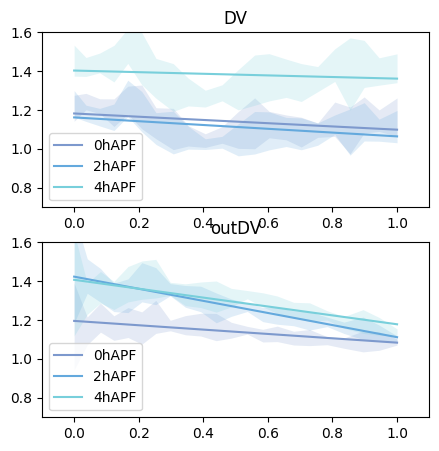

In [16]:
#plot lambda_area_mean vs cumcount_mean for each devstage_final
lambda_name = "lambda_area"
fig,axs = plt.subplots(2,1, figsize=(5,5))
regions = ["DV", "outDV"]
for i in range(len(regions)):
    region = regions[i]
    ax = axs[i]

    for j in range(len(devstage_combinations)):

        devstage_init = devstage_combinations.loc[j,"devstage_init"]
        devstage_final = devstage_combinations.loc[j,"devstage_final"]

        df_temp = df_comparison[(df_comparison["region"] == region)&(df_comparison["devstage_init"] == devstage_init)&(df_comparison["devstage_final"] == devstage_final)]

        ax.plot(df_temp["ref_pathlength_scaled"], df_temp["fit_" + lambda_name + "_mean"], label=devstage_final, color = color_dict[devstage_final])
        ax.fill_between(df_temp["ref_pathlength_scaled"], df_temp[lambda_name + "_mean"]-df_temp[lambda_name + "_std"], df_temp[lambda_name + "_mean"]+df_temp[lambda_name + "_std"], alpha=0.2, color = color_dict[devstage_final], linewidth=0)

    ax.set_title(region)
    ax.set_ylim(0.7,1.6)
    ax.set_xlim(-0.1,1.1)
    ax.legend()



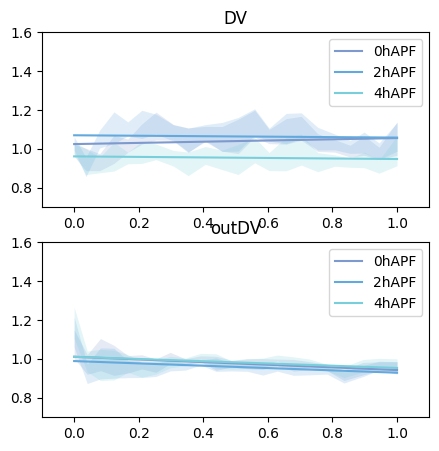

In [17]:
#plot lambda_area_mean vs cumcount_mean for each devstage_final
lambda_name = "lambda_elongation"
fig,axs = plt.subplots(2,1, figsize=(5,5))
regions = ["DV", "outDV"]
for i in range(len(regions)):
    region = regions[i]
    ax = axs[i]

    for j in range(len(devstage_combinations)):

        devstage_init = devstage_combinations.loc[j,"devstage_init"]
        devstage_final = devstage_combinations.loc[j,"devstage_final"]

        df_temp = df_comparison[(df_comparison["region"] == region)&(df_comparison["devstage_init"] == devstage_init)&(df_comparison["devstage_final"] == devstage_final)]

        ax.plot(df_temp["ref_pathlength_scaled"], df_temp["fit_" + lambda_name + "_mean"], label=devstage_final, color = color_dict[devstage_final])
        ax.fill_between(df_temp["ref_pathlength_scaled"], df_temp[lambda_name + "_mean"]-df_temp[lambda_name + "_std"], df_temp[lambda_name + "_mean"]+df_temp[lambda_name + "_std"], alpha=0.2, color = color_dict[devstage_final], linewidth=0)

    ax.set_title(region)
    ax.set_ylim(0.7,1.6)
    ax.set_xlim(-0.1,1.1)
    ax.legend()



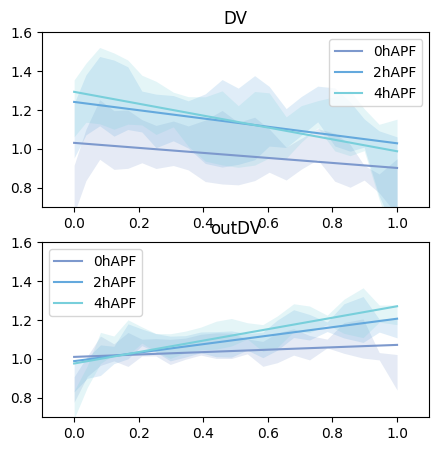

In [18]:
#plot lambda_area_mean vs cumcount_mean for each devstage_final
lambda_name = "lambda_rearrangement"
fig,axs = plt.subplots(2,1, figsize=(5,5))
regions = ["DV", "outDV"]
for i in range(len(regions)):
    region = regions[i]
    ax = axs[i]

    for j in range(len(devstage_combinations)):

        devstage_init = devstage_combinations.loc[j,"devstage_init"]
        devstage_final = devstage_combinations.loc[j,"devstage_final"]

        df_temp = df_comparison[(df_comparison["region"] == region)&(df_comparison["devstage_init"] == devstage_init)&(df_comparison["devstage_final"] == devstage_final)]

        ax.plot(df_temp["ref_pathlength_scaled"], df_temp["fit_" + lambda_name + "_mean"], label=devstage_final, color = color_dict[devstage_final])
        ax.fill_between(df_temp["ref_pathlength_scaled"], df_temp[lambda_name + "_mean"]-df_temp[lambda_name + "_std"], df_temp[lambda_name + "_mean"]+df_temp[lambda_name + "_std"], alpha=0.2, color = color_dict[devstage_final], linewidth=0)
        #ax.fill_betweenx(df_temp[lambda_name + "_mean"], df_temp["ref_pathlength_scaled"] - df_temp["ref_pathlength_scaled_std"], df_temp["ref_pathlength_scaled"] + df_temp["ref_pathlength_scaled_std"], alpha=0.2, color = color_dict[devstage_final])

    ax.set_title(region)
    ax.set_ylim(0.7,1.6)
    ax.set_xlim(-0.1,1.1)
    ax.legend()



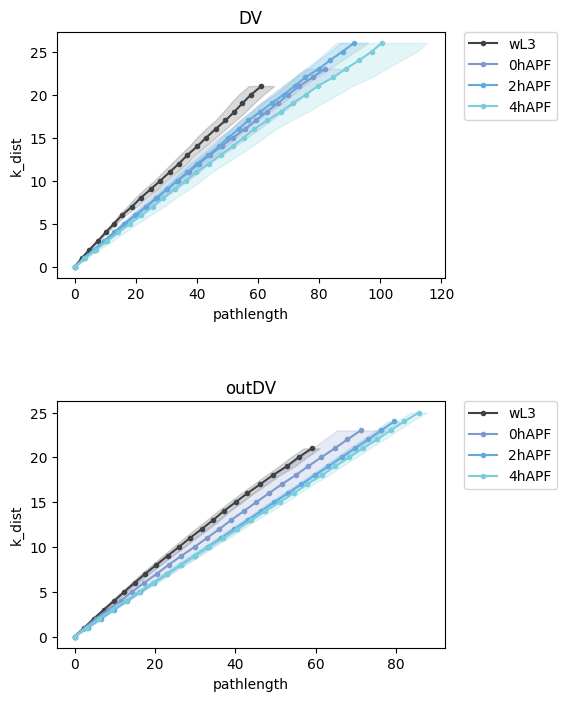

In [19]:
#plot k_dist vs cumcount for each devstage and each region

fig, axs = plt.subplots(2, 1, figsize=(5, 8))

regions = ["DV", "outDV"]
devstages = ["wL3", "0hAPF", "2hAPF", "4hAPF"]

for i in range(len(regions)):

    region = regions[i]
    ax = axs[i]

    for j in range(len(devstages)):

        df_stage = df_pool_devstage.query("region == @region and devstage == @devstages[@j]")

        #ax.plot(df_stage["cumcount_mean"], df_stage["k_dist"], label=devstages[j], marker="o", linestyle="-", color = color_dict[devstages[j]], markersize = 3) 
        ax.plot(df_stage["k_dist_pathlength_mean"], df_stage["k_dist"], label=devstages[j], marker="o", linestyle="-", color = color_dict[devstages[j]], markersize = 3) 
        #fill between y and x1 and x2
        ax.fill_betweenx(df_stage["k_dist"], df_stage["k_dist_pathlength_mean"] - df_stage["k_dist_pathlength_std"], df_stage["k_dist_pathlength_mean"] + df_stage["k_dist_pathlength_std"], alpha=0.2, color = color_dict[devstages[j]])

    #legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_xlabel("pathlength")
    ax.set_ylabel("k_dist")
    ax.set_title(region)

    #ax.set_ylim([-1, 5.5])
    #ax.set_xlim([0, 55])

#give some space between subplots
plt.subplots_adjust(hspace = 0.5)